In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io
import os
data_root = '/home/hanjiechen/YanweiJIN/Data/MMData'
result_root = '/home/hanjiechen/YanweiJIN/BP_est/bp_result/MMData'
fs = 2000
Sub = {}
Sub['sub_id'] = list(os.walk(data_root))[0][1]

In [2]:
def process_subject(i):
    print(f"Subject {Sub['sub_id'][i]}")
    Sub[f"{Sub['sub_id'][i]}"] = {}
    result_path = f"{result_root}/{Sub['sub_id'][i]}"
    if not os.path.exists(result_path):
        os.makedirs(result_path)

    ## Read all '.mat' data in one Subject
    rest1_s = []
    CT_s = []
    recover_s = []
    rest2_s = []
    Sub[f"{Sub['sub_id'][i]}"]['seg'] = [n.split('.')[0] for n in list(os.walk(data_root))[i+1][2]]
    print(Sub[f"{Sub['sub_id'][i]}"]['seg'])
    for s in Sub[f"{Sub['sub_id'][i]}"]['seg']:
        Sub[f"{Sub['sub_id'][i]}"][s] = scipy.io.loadmat(f"{data_root}/{Sub['sub_id'][i]}/{s}.mat")[s]
        for r in s.split('_'):
            if r in ['recover', 're', 'Recover']: #this seg is one of Recover
                recover_s.append(s)
            elif r in ['rest1']:
                rest1_s.append(s)
            elif r in ['CT', 'ct']:
                CT_s.append(s)
            elif r in ['rest2']:
                rest2_s.append(s)
            elif r in ['rest']:
                rest_index = s.split('_').index('rest')
                if s.split('_')[rest_index + 1] == '1':
                    rest1_s.append(s)
                else:
                    rest2_s.append(s)

    #print(rest1_s)
    ## Type 4 stage in one Subject
    Sub[f"{Sub['sub_id'][i]}"]['rest1'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in rest1_s], axis=1)
    r1code = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['rest1'].shape[1]), 1)
    Sub[f"{Sub['sub_id'][i]}"]['rest1'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['rest1'], r1code), axis=0)
    Sub[f"{Sub['sub_id'][i]}"]['CT'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in CT_s], axis=1)
    CTcode = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['CT'].shape[1]), 2)
    Sub[f"{Sub['sub_id'][i]}"]['CT'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['CT'], CTcode), axis=0)
    Sub[f"{Sub['sub_id'][i]}"]['recover'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in recover_s], axis=1)
    recode = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['recover'].shape[1]), 3)
    Sub[f"{Sub['sub_id'][i]}"]['recover'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['recover'], recode), axis=0)
    Sub[f"{Sub['sub_id'][i]}"]['rest2'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in rest2_s], axis=1)
    r2code = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['rest2'].shape[1]), 4)
    Sub[f"{Sub['sub_id'][i]}"]['rest2'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['rest2'], r2code), axis=0)
    ## Concat to on entire one
    Sub[f"{Sub['sub_id'][i]}"]['data'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['rest1'], Sub[f"{Sub['sub_id'][i]}"]['CT'], Sub[f"{Sub['sub_id'][i]}"]['recover'], Sub[f"{Sub['sub_id'][i]}"]['rest2']), axis=1)
    print(len(Sub[f"{Sub['sub_id'][i]}"]['data'][0]))
    
    ## Get 5 signals and show
    tags = ['ECG', 'CBP', 'PPG', 'IPG', 'Temp', 'Stage', 'ECGf']
    for da in range(6):
        Sub[f"{Sub['sub_id'][i]}"][f"{tags[da]}"] = Sub[f"{Sub['sub_id'][i]}"]['data'][da]
    
    begin_index, end_index = 0, 30000 #S1.shape[1]
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(18, 10), dpi=96)
    for sgn in range(5):
        axs[sgn].plot(Sub[f"{Sub['sub_id'][i]}"]['data'][sgn][begin_index:end_index])
        axs[sgn].set_title(f"{tags[sgn]}")
    fig.subplots_adjust(hspace=0.55)
    plt.savefig(f"{result_path}/S{Sub['sub_id'][i]}_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
    plt.show()

    ## Filter ECG and show
    ecg_signal = Sub[f"{Sub['sub_id'][i]}"]['ECG']
    lowcut = 10.0
    highcut = 50.0
    order = 4
    b,a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
    ecg_filtered = signal.filtfilt(b, a, ecg_signal)
    Sub[f"{Sub['sub_id'][i]}"]['ECGf'] = ecg_filtered
    #print(f"filtered_ecg: {ecg_filtered}")

    begin_index, end_index = 0, 30000
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,4),dpi=96)
    axs[0].plot(ecg_signal[begin_index:end_index])
    #axs[0].legend()
    axs[0].set_title(f"S{Sub['sub_id'][i]}_Original ECG_{int(begin_index/fs)}to{int(end_index/fs)}sec")
    axs[1].plot(ecg_filtered[begin_index:end_index])
    #axs[1].legend()
    axs[1].set_title(f"S{Sub['sub_id'][i]}_Filtered ECG_{int(begin_index/fs)}to{int(end_index/fs)}sec")
    fig.subplots_adjust(hspace=0.55)
    plt.savefig(f"{result_path}/S{Sub['sub_id'][i]}_Ori&Fil_ECG_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
    plt.show()

    ## Find peaks
    peak_window = 20 * fs # 20sec per detecting
    seg_index = list(range(0, len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']), peak_window))
    seg_index.append(len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']))
    #print(f"Seg_index: {seg_index}")

    r_peak_index = []
    for sr in range(len(seg_index) - 1): #len(seg_index) - 1
        ecg_peak_signal = Sub[f"{Sub['sub_id'][i]}"]['ECGf'][seg_index[sr]:seg_index[sr+1]]
        height = 0.5 * np.max(ecg_peak_signal)
        distance = 60 / 100 * fs
        #prominence = 0.5 * (np.max(filtered_ecg) - np.min(filtered_ecg))
        r_peak_index_seg, r_peak_value_fil = signal.find_peaks(ecg_peak_signal, height=height, distance=distance)
        r_peak_index += list(r_peak_index_seg + seg_index[sr])
    print(f"R peak index: {len(r_peak_index)}, {r_peak_index}")

    sbp_index = []
    dbp_index = []
    max_ppg_index = []
    min_ppg_index = []
    high_ipg_index = []
    low_ipg_index = []
    for ri in range(len(r_peak_index)-1):
        cbp_seg = Sub[f"{Sub['sub_id'][i]}"]['CBP'][r_peak_index[ri]:r_peak_index[ri+1]]
        sbp_index.append(r_peak_index[ri] + np.argmax(cbp_seg))
        cbp_seg_half = Sub[f"{Sub['sub_id'][i]}"]['CBP'][r_peak_index[ri]:sbp_index[-1]]
        dbp_index.append(r_peak_index[ri] + np.argmin(cbp_seg_half))
        ppg_seg = Sub[f"{Sub['sub_id'][i]}"]['PPG'][r_peak_index[ri]:r_peak_index[ri+1]]
        if np.argmax(ppg_seg) > np.argmax(ppg_seg):
            max_ppg_index.append(r_peak_index[ri] + np.argmax(ppg_seg))
            min_ppg_index.append(r_peak_index[ri] + np.argmin(ppg_seg))
        else:
            centre_index = int(len(ppg_seg) / 2)
            maxppgdis = abs(np.argmax(ppg_seg) - centre_index)
            minppgdis = abs(np.argmin(ppg_seg) - centre_index)
            if maxppgdis < minppgdis: # maxppg_index is right
                max_ppg_index.append(r_peak_index[ri] + np.argmax(ppg_seg))
                ppg_seg_half = Sub[f"{Sub['sub_id'][i]}"]['PPG'][r_peak_index[ri]:max_ppg_index[-1]]
                min_ppg_index.append(r_peak_index[ri] + np.argmin(ppg_seg_half))
            else: #minppg_index is right
                pmini = np.argmin(ppg_seg)
                rppg_seg = ppg_seg[pmini:]
                max_ppg_index.append(r_peak_index[ri] + pmini + np.argmax(rppg_seg))
                min_ppg_index.append(r_peak_index[ri] + pmini)
            
        ipg_seg = Sub[f"{Sub['sub_id'][i]}"]['IPG'][r_peak_index[ri]:r_peak_index[ri+1]]
        low_ipg_index.append(r_peak_index[ri] + np.argmin(ipg_seg))
        ipg_seg_half = Sub[f"{Sub['sub_id'][i]}"]['IPG'][r_peak_index[ri]:low_ipg_index[-1]]
        if len(ipg_seg_half) > 0:
            high_ipg_index.append(r_peak_index[ri] + np.argmax(ipg_seg_half))
        else:
            high_ipg_index.append(r_peak_index[ri])
    print(f"SBP index: {len(sbp_index)}, {sbp_index}\nDBP index: {len(dbp_index)}, {dbp_index}")
    print(f"Max PPG index: {len(max_ppg_index)}, {max_ppg_index}\nMin PPG index: {len(min_ppg_index)}, {min_ppg_index}")
    print(f"High IPG index: {len(high_ipg_index)}, {high_ipg_index}\nLow IPG index: {len(low_ipg_index)}, {low_ipg_index}")

    begin_index = 0
    end_index = len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']) #len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']) #10 * peak_window
    fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(18, 10), dpi=96)
    axs[0].plot(Sub[f"{Sub['sub_id'][i]}"]['ECGf'][begin_index:end_index])
    axs[0].scatter(r_peak_index, Sub[f"{Sub['sub_id'][i]}"]['ECGf'][r_peak_index], label='R peak')
    axs[0].set_title('ECG')
    axs[0].legend()

    axs[1].plot(Sub[f"{Sub['sub_id'][i]}"]['CBP'][begin_index:end_index])
    axs[1].scatter(sbp_index, Sub[f"{Sub['sub_id'][i]}"]['CBP'][sbp_index],label='SBP')
    axs[1].scatter(dbp_index, Sub[f"{Sub['sub_id'][i]}"]['CBP'][dbp_index],label='DBP')
    axs[1].set_title('CBP')
    axs[1].legend()

    axs[2].plot(Sub[f"{Sub['sub_id'][i]}"]['PPG'][begin_index:end_index])
    axs[2].scatter(max_ppg_index, Sub[f"{Sub['sub_id'][i]}"]['PPG'][max_ppg_index], label='Max PPG')
    axs[2].scatter(min_ppg_index, Sub[f"{Sub['sub_id'][i]}"]['PPG'][min_ppg_index], label='Min PPG')
    axs[2].set_title('PPG')
    axs[2].legend()

    axs[3].plot(Sub[f"{Sub['sub_id'][i]}"]['IPG'][begin_index:end_index])
    axs[3].scatter(high_ipg_index, Sub[f"{Sub['sub_id'][i]}"]['IPG'][high_ipg_index],label='High IPG')
    axs[3].scatter(low_ipg_index, Sub[f"{Sub['sub_id'][i]}"]['IPG'][low_ipg_index],label='Low IPG')
    axs[3].set_title('IPG')
    axs[3].legend()

    axs[4].plot(Sub[f"{Sub['sub_id'][i]}"]['Temp'][begin_index:end_index])
    axs[4].set_title('Temp')

    axs[5].plot(Sub[f"{Sub['sub_id'][i]}"]['Stage'][begin_index:end_index])
    axs[5].set_title('Stage')
    fig.subplots_adjust(hspace=0.55)
    plt.savefig(f"{result_path}/S{Sub['sub_id'][i]}_{len(r_peak_index)}Keypoints_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
    plt.show()

    ## Get Features
    features = {}
    features['Stage'] = Sub[f"{Sub['sub_id'][i]}"]['Stage'][r_peak_index[:-1]]
    features['heart_rate'] = [(r_peak_index[rpi+1] - r_peak_index[rpi])/fs for rpi in range(len(r_peak_index)-1)]
    print(f"max HR:{max(features['heart_rate'])}, min HR:{min(features['heart_rate'])}, len HR:{len(features['heart_rate'])}")
    features['R_peak'] = Sub[f"{Sub['sub_id'][i]}"]['ECGf'][r_peak_index[:-1]]
    print(f"max R_peak:{max(features['R_peak'])}, min R_peak:{min(features['R_peak'])}, len R_peak:{len(features['R_peak'])}")
    features['PTT'] = [(max_ppg_index[mpi] - r_peak_index[mpi]) / fs for mpi in range(len(max_ppg_index))]
    print(f"max PTT:{max(features['PTT'])}, min PTT:{min(features['PTT'])}, len PTT:{len(features['PTT'])}")
    features['Max_PPG'] = Sub[f"{Sub['sub_id'][i]}"]['PPG'][max_ppg_index]
    print(f"max Max_PPG:{max(features['Max_PPG'])}, min Max_PPG:{min(features['Max_PPG'])}, len Max_PPG:{len(features['Max_PPG'])}")
    features['Min_PPG'] = Sub[f"{Sub['sub_id'][i]}"]['PPG'][min_ppg_index]
    print(f"max Min_PPG:{max(features['Min_PPG'])}, min Min_PPG:{min(features['Min_PPG'])}, len Min_PPG:{len(features['Min_PPG'])}")
    features['dPPG'] = features['Max_PPG'] - features['Min_PPG']
    print(f"max dPPG:{max(features['dPPG'])}, min dPPG:{min(features['dPPG'])}, len dPPG:{len(features['dPPG'])}")
    features['PPG_width'] = [(min_ppg_index[mpi+1] - min_ppg_index[mpi])/fs for mpi in range(len(min_ppg_index) - 1)]
    features['PPG_width'].append((r_peak_index[-1] - min_ppg_index[-1])/fs)
    print(f"max PPG_width:{max(features['PPG_width'])}, min PPG_width:{min(features['PPG_width'])}, len PPG_width:{len(features['PPG_width'])}")
    features['High_IPG'] = Sub[f"{Sub['sub_id'][i]}"]['IPG'][high_ipg_index]
    print(f"max High_IPG:{max(features['High_IPG'])}, min High_IPG:{min(features['High_IPG'])}, len High_IPG:{len(features['High_IPG'])}")
    features['Low_IPG'] = Sub[f"{Sub['sub_id'][i]}"]['IPG'][low_ipg_index]
    print(f"max Low_IPG:{max(features['Low_IPG'])}, min Low_IPG:{min(features['Low_IPG'])}, len Low_IPG:{len(features['Low_IPG'])}")
    features['dIPG'] = features['High_IPG'] - features['Low_IPG']
    print(f"max dIPG:{max(features['dIPG'])}, min dIPG:{min(features['dIPG'])}, len dIPG:{len(features['dIPG'])}")
    features['IPG_small_area'] = []
    features['IPG_large_area'] = []
    max_ipg = max(Sub[f"{Sub['sub_id'][i]}"]['IPG'])
    for rpi in range(len(r_peak_index) - 1):
        ipg_seg = Sub[f"{Sub['sub_id'][i]}"]['IPG'][r_peak_index[rpi]:r_peak_index[rpi+1]]
        features['IPG_small_area'].append(sum([(max(ipg_seg) - ipg_seg[d]) for d in range(len(ipg_seg))]) / fs)
        features['IPG_large_area'].append(sum([(max_ipg - ipg_seg[d]) for d in range(len(ipg_seg))]) / fs)
    print(f"max IPG_small_area:{max(features['IPG_small_area'])}, min IPG_small_area:{min(features['IPG_small_area'])}, len IPG_small_area:{len(features['IPG_small_area'])}")   
    print(f"max IPG_large_area:{max(features['IPG_large_area'])}, min IPG_large_area:{min(features['IPG_large_area'])}, len IPG_large_area:{len(features['IPG_large_area'])}")
    features['ave_Temp'] = [np.mean(Sub[f"{Sub['sub_id'][i]}"]['Temp'][r_peak_index[rpi]: r_peak_index[rpi+1]]) for rpi in range(len(r_peak_index) - 1)]
    print(f"max ave_Temp:{max(features['ave_Temp'])}, min ave_Temp:{min(features['ave_Temp'])}, len ave_Temp:{len(features['ave_Temp'])}")
    features['SBP'] = Sub[f"{Sub['sub_id'][i]}"]['CBP'][sbp_index]
    print(f"max SBP:{max(features['SBP'])}, min SBP:{min(features['SBP'])}, len SBP:{len(features['SBP'])}")
    features['DBP'] = Sub[f"{Sub['sub_id'][i]}"]['CBP'][dbp_index]
    print(f"max DBP:{max(features['DBP'])}, min DBP:{min(features['DBP'])}, len DBP:{len(features['DBP'])}")
    features['PBP'] = features['SBP'] - features['DBP']
    print(f"max PBP:{max(features['PBP'])}, min PBP:{min(features['PBP'])}, len PBP:{len(features['PBP'])}")

    features_df = pd.DataFrame(features)
    features_df.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_OriginalFeatures.csv")
    #display(features_df)

    ## Select Features in right scale
    features_fil_df = features_df[
        (features_df['IPG_small_area'] < 3 * np.mean(features['IPG_small_area'])) & 
        (0.6 <= features_df['heart_rate']) &
        (features_df['heart_rate'] <=1) & 
        (0.2 <= features_df['PTT']) & 
        (features_df['dPPG'] != 0)
        ]

    ## Reorder features to make every stage of subject could be train
    split_rate = 0.7
    f_rest1_df = features_fil_df[features_fil_df['Stage'] == 1]
    #print(f_rest1_df.shape)
    f_CT_df = features_fil_df[features_fil_df['Stage'] == 2]
    #print(f_CT_df.shape)
    f_recover_df = features_fil_df[features_fil_df['Stage'] == 3]
    #print(f_recover_df.shape)
    f_rest2_df = features_fil_df[features_fil_df['Stage'] == 4]
    #print(f_rest2_df.shape)

    f_train = pd.concat((f_rest1_df[:int(split_rate * len(f_rest1_df))], f_CT_df[:int(split_rate * len(f_CT_df))], f_recover_df[:int(split_rate * len(f_recover_df))], f_rest2_df[:int(split_rate * len(f_rest2_df))]), ignore_index=True)
    f_train.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_TrainFeatures.csv")
    #display(f_train)
    f_test = pd.concat((f_rest1_df[int(split_rate * len(f_rest1_df)) : ], f_CT_df[int(split_rate * len(f_CT_df)) : ], f_recover_df[int(split_rate * len(f_recover_df)) : ], f_rest2_df[int(split_rate * len(f_rest2_df)) : ]), axis=0, ignore_index=True)
    f_test.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_TestFeatures.csv")
    #display(f_test)
    f_reod = pd.concat((f_train, f_test), ignore_index=True)
    f_reod.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_ReorderedFeatures.csv")
    display(f_reod)
    return

Subject 11
['processed_rest1_1', 'processed_ct', 'processed_rest2_1', 'processed_rest1_2', 'processed_re']
1320071


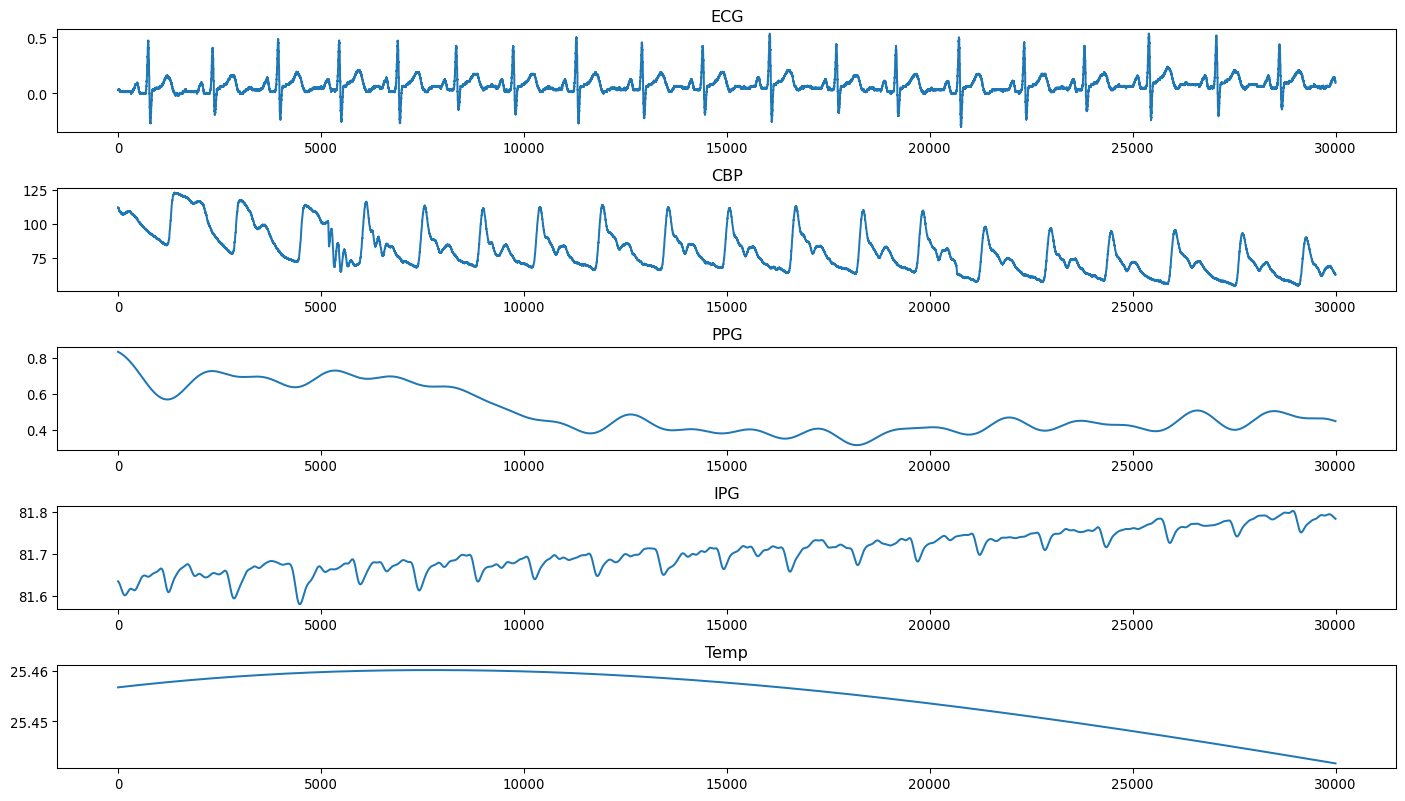

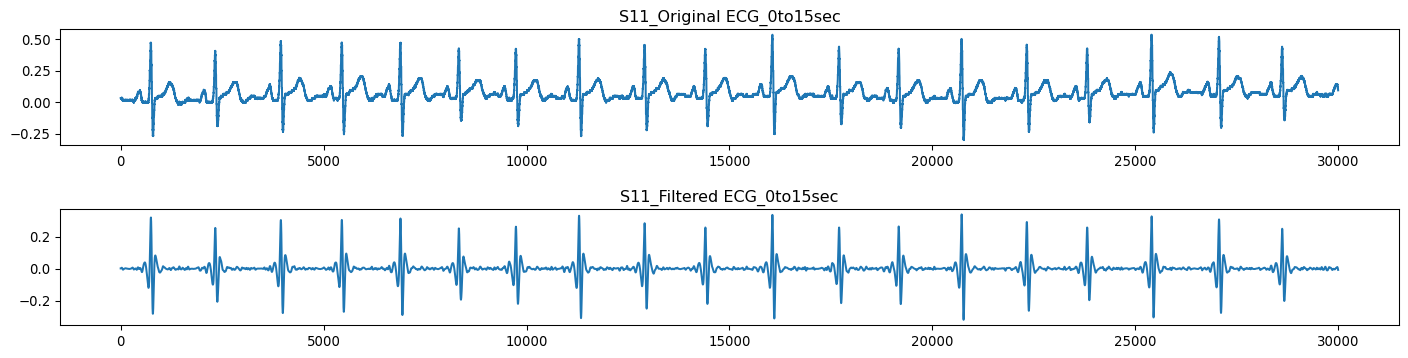

R peak index: 813, [744, 2331, 3947, 5449, 6894, 8333, 9739, 11295, 12910, 14407, 16058, 17702, 19171, 20722, 22328, 23816, 25403, 27064, 28620, 30239, 31922, 33408, 34970, 36590, 38106, 39727, 41454, 43125, 44791, 46537, 48205, 49845, 51552, 53136, 54748, 56447, 58069, 59766, 61565, 63270, 64964, 66734, 68359, 69989, 71641, 73169, 74807, 76542, 78244, 79975, 81766, 83470, 85180, 86933, 88597, 90215, 91877, 93522, 95097, 96770, 98456, 100162, 101955, 103594, 105341, 107139, 108809, 110603, 112451, 114204, 116040, 117924, 119641, 121476, 123308, 124972, 126728, 128484, 130138, 131881, 133669, 135441, 137338, 140144, 142047, 143810, 145661, 147565, 149339, 151061, 152866, 154694, 156469, 158310, 160185, 161915, 163721, 165523, 167147, 168905, 170733, 172419, 174248, 176145, 177865, 179707, 181624, 183393, 185169, 186956, 188592, 190352, 192184, 193906, 195754, 197656, 199435, 201336, 203177, 205037, 206914, 208662, 210515, 212350, 214144, 215987, 217674, 219451, 221177, 222821, 224542, 2

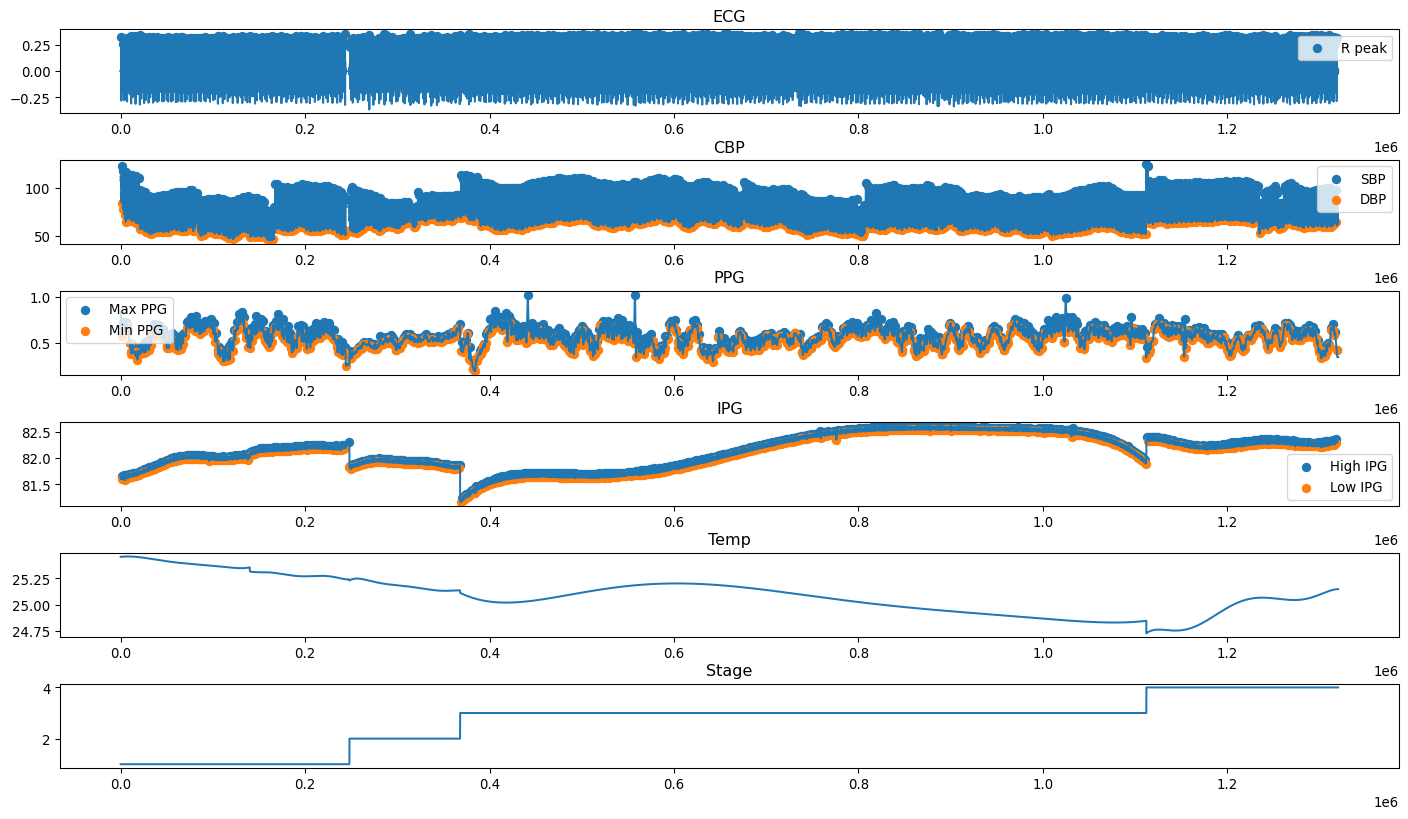

max HR:2.6945, min HR:0.652, len HR:812
max R_peak:0.365002888074631, min R_peak:0.19897074564502584, len R_peak:812
max PTT:2.5995, min PTT:0.0025, len PTT:812
max Max_PPG:1.0282610019728962, min Max_PPG:0.2074809578633351, len Max_PPG:812
max Min_PPG:0.7331492786011606, min Min_PPG:0.1836508304532013, len Min_PPG:812
max dPPG:0.5305100736339916, min dPPG:0.0, len dPPG:812
max PPG_width:2.775, min PPG_width:0.0005, len PPG_width:812
max High_IPG:82.61751906598992, min High_IPG:81.24946411613486, len High_IPG:812
max Low_IPG:82.54949456091344, min Low_IPG:81.15837027882871, len Low_IPG:812
max dIPG:0.7105273868999973, min dIPG:0.03570729277659268, len dIPG:812
max IPG_small_area:0.6773519196633935, min IPG_small_area:0.008525940113341115, len IPG_small_area:812
max IPG_large_area:1.5929158921828601, min IPG_large_area:0.027004271471001835, len IPG_large_area:812
max ave_Temp:25.4601330793295, min ave_Temp:24.73468669646217, len ave_Temp:812
max SBP:125.15245934441732, min SBP:69.518965

,Stage,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,1.0,0.7935,0.320052,0.7855,0.726087,0.567755,0.158332,1.3660,81.664701,81.607835,0.056866,0.019730,0.767582,25.457973,122.711055,84.045319,38.665736
1,1.0,0.7510,0.303911,0.6985,0.728981,0.635738,0.093243,0.8960,81.677973,81.579095,0.098878,0.021959,0.727558,25.459634,113.616825,71.685712,41.931114
2,1.0,0.7225,0.304806,0.6235,0.696443,0.682794,0.013649,1.0885,81.686955,81.626653,0.060302,0.014619,0.686951,25.460004,116.027712,64.758228,51.269484
3,1.0,0.8075,0.331105,0.6675,0.484349,0.378849,0.105500,1.3840,81.700344,81.646636,0.053709,0.016026,0.751926,25.459193,113.738896,65.856859,47.882036
4,1.0,0.8255,0.257352,0.5770,0.401198,0.378665,0.022533,0.7800,81.714401,81.663142,0.051259,0.012509,0.754684,25.457485,111.419562,67.321702,44.097860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,4.0,0.7635,0.314845,0.7470,0.496340,0.402028,0.094313,1.3175,82.323805,82.230792,0.093014,0.027088,0.251338,25.123589,95.703023,58.685235,37.017788
658,4.0,0.7785,0.340177,0.7780,0.660226,0.456900,0.203326,0.9455,82.321180,82.243259,0.077921,0.017322,0.248022,25.133284,99.578752,60.516288,39.062464
659,4.0,0.7725,0.267290,0.6570,0.659827,0.638235,0.021592,0.6390,82.331721,82.258873,0.072848,0.017806,0.238585,25.137425,90.270900,59.631279,30.639620
660,4.0,0.8085,0.323654,0.6195,0.703807,0.642166,0.061641,0.9585,82.344235,82.269128,0.075106,0.021322,0.242272,25.141060,93.353172,60.913016,32.440156


Subject 2
['processed_recover_1_2', 'processed_recover_1_1', 'processed_rest2_1', 'processed_CT_1', 'processed_rest1_1_1']
996222


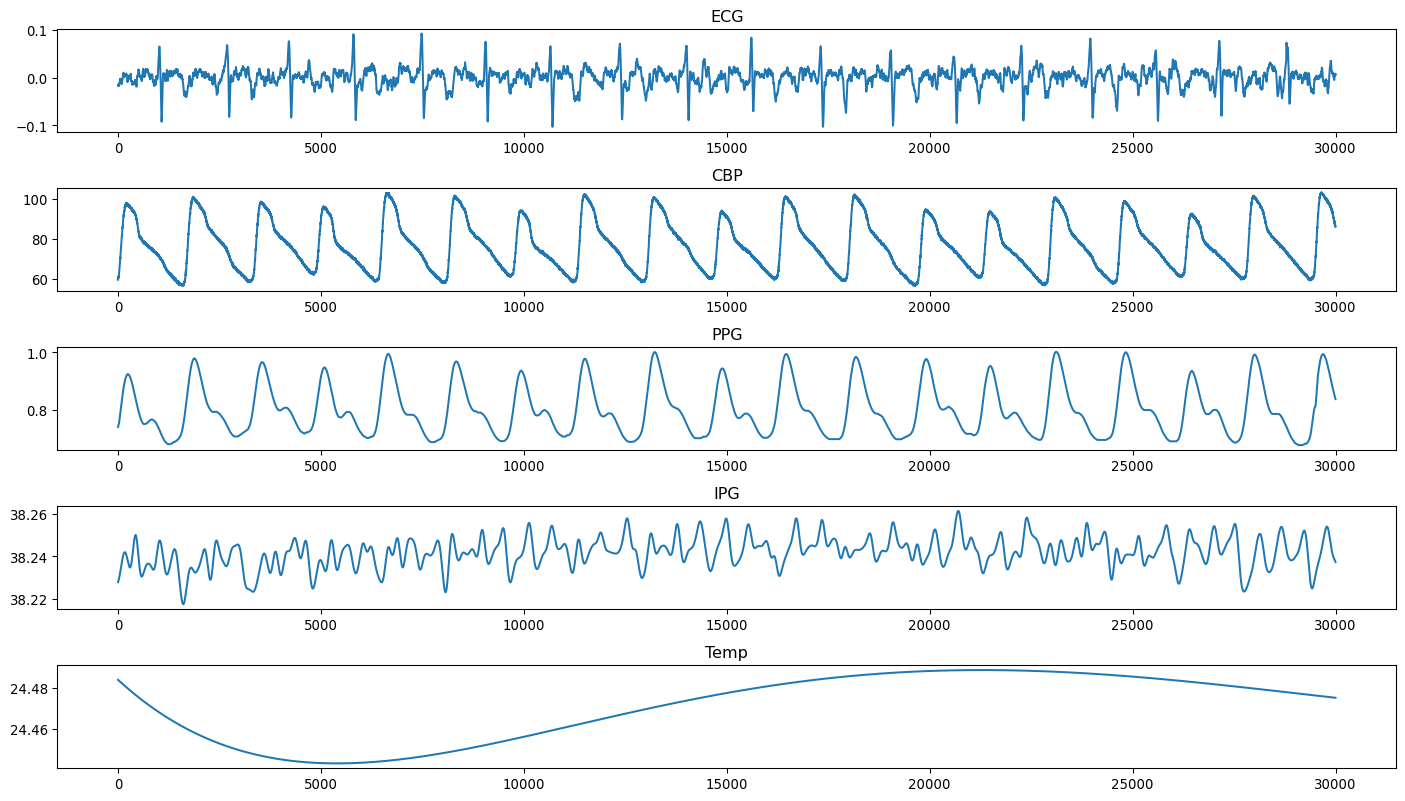

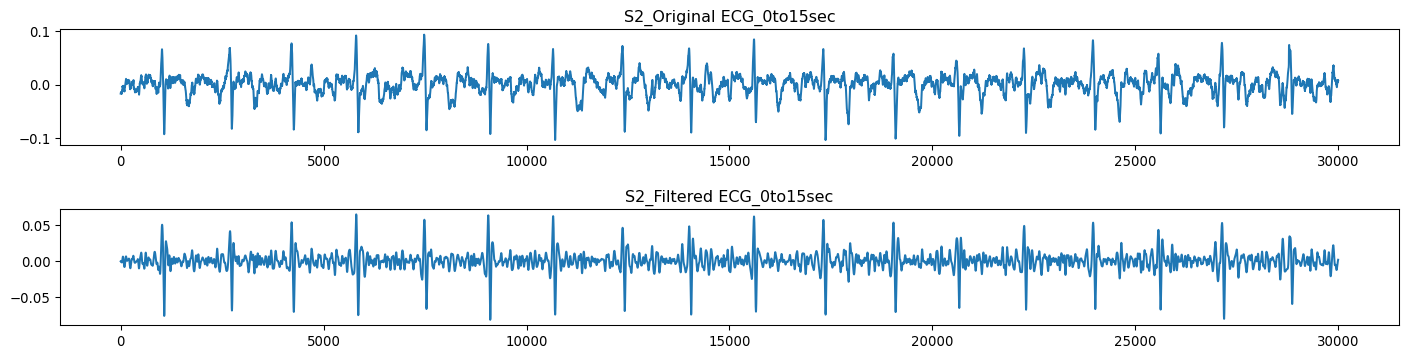

R peak index: 597, [1021, 2695, 4212, 5804, 7483, 9057, 10656, 12368, 14008, 15606, 17316, 19042, 22263, 23961, 25571, 27139, 28801, 30530, 32107, 33765, 35506, 37239, 38814, 40425, 42080, 43700, 45212, 46819, 48435, 50110, 51672, 53194, 54790, 56386, 57960, 59425, 60950, 62511, 64115, 65686, 67168, 68436, 70815, 72020, 73225, 74461, 75717, 76978, 78251, 79539, 80877, 82298, 83692, 85038, 86377, 87760, 89216, 90666, 93425, 94918, 96463, 98040, 99632, 100955, 102426, 103937, 105500, 107074, 110029, 113100, 114523, 115973, 117494, 119018, 120476, 121940, 123425, 124946, 126492, 127920, 129378, 130894, 132481, 134055, 135522, 137006, 138365, 140135, 141610, 143119, 144681, 146239, 147874, 149414, 151030, 152669, 154306, 155841, 157421, 159039, 160662, 162193, 163734, 166339, 167941, 169634, 171354, 173109, 174733, 176358, 177994, 179673, 181375, 182964, 184613, 186304, 188069, 189688, 191330, 193003, 194582, 196273, 197982, 199576, 201210, 202892, 204611, 206218, 207892, 209507, 212813, 2

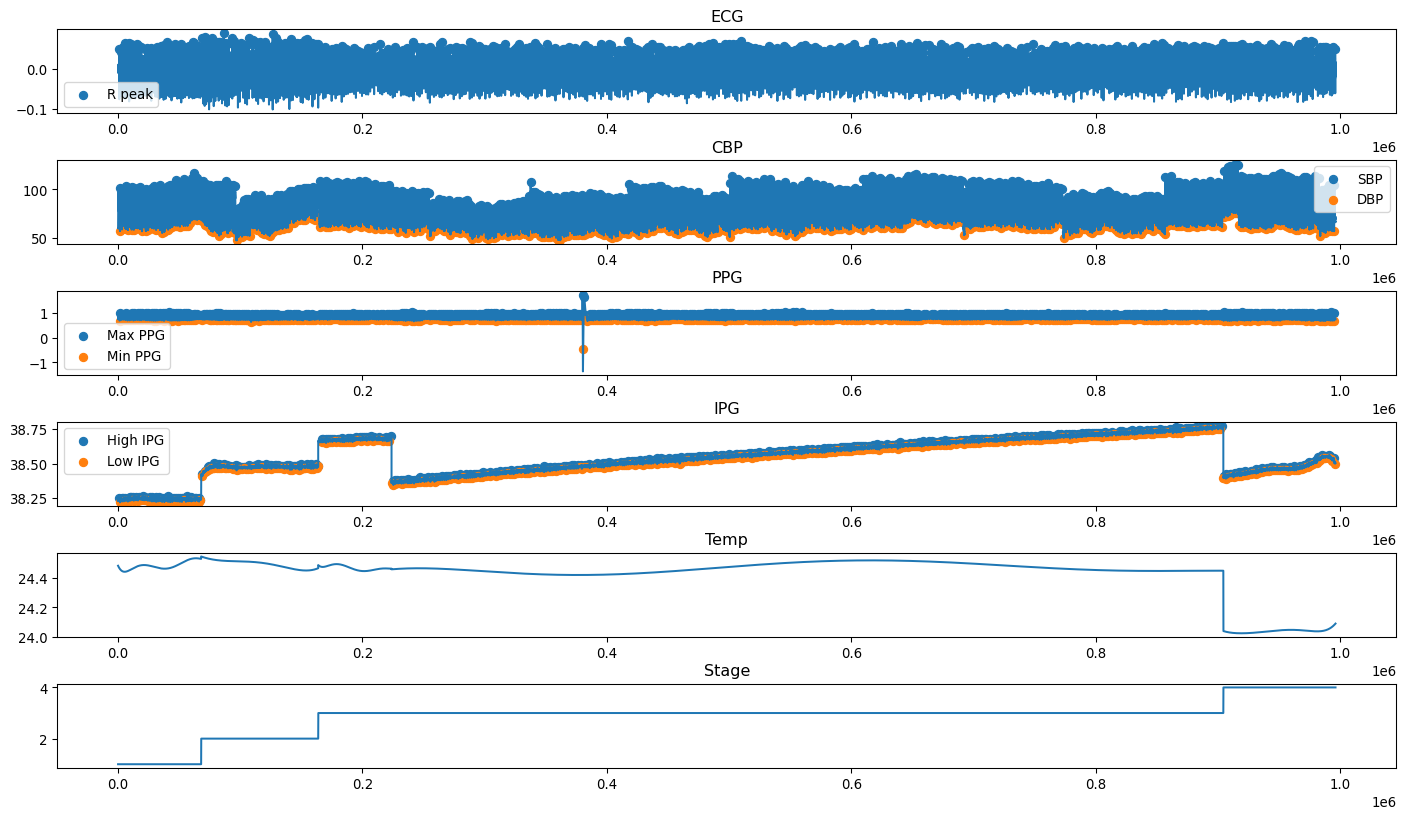

max HR:1.6905, min HR:0.0495, len HR:596
max R_peak:0.08988532318336494, min R_peak:0.0293042133732392, len R_peak:596
max PTT:1.295, min PTT:0.049, len PTT:596
max Max_PPG:1.7312335659382845, min Max_PPG:0.7330593218418738, len Max_PPG:596
max Min_PPG:0.755569228971596, min Min_PPG:-0.47190704094644587, len Min_PPG:596
max dPPG:2.1238448657381044, min dPPG:0.0, len dPPG:596
max PPG_width:1.8235, min PPG_width:0.162, len PPG_width:596
max High_IPG:38.7763820509201, min High_IPG:38.23426405536669, len High_IPG:596
max Low_IPG:38.754107869462516, min Low_IPG:38.217490544036124, len Low_IPG:596
max dIPG:0.3809940445968465, min dIPG:0.0, len dIPG:596
max IPG_small_area:0.1719968351969128, min IPG_small_area:0.00012645495125441998, len IPG_small_area:596
max IPG_large_area:0.8579246678108985, min IPG_large_area:0.0032168251427931267, len IPG_large_area:596
max ave_Temp:24.542341920775645, min ave_Temp:24.024088793689632, len ave_Temp:596
max SBP:126.64781929980188, min SBP:76.41593181892459

,Stage,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,1.0,0.8370,0.050087,0.4295,0.979162,0.682364,0.296798,0.8125,38.247481,38.217491,0.029990,0.009869,0.452548,24.458626,101.165665,56.732112,44.433553
1,1.0,0.7585,0.041190,0.4260,0.965869,0.709296,0.256573,0.8615,38.245592,38.223341,0.022250,0.007516,0.410120,24.447192,98.724261,58.471612,40.252649
2,1.0,0.7960,0.053437,0.4375,0.948106,0.719092,0.229013,0.7895,38.248678,38.224873,0.023804,0.007155,0.427208,24.443212,96.191304,62.133718,34.057586
3,1.0,0.8395,0.064383,0.4255,0.994365,0.703946,0.290419,0.8070,38.246187,38.227799,0.018388,0.007156,0.450253,24.444316,103.027236,58.746270,44.280965
4,1.0,0.7870,0.057008,0.4250,0.968534,0.689912,0.278623,0.8390,38.247487,38.223165,0.024322,0.008742,0.421074,24.448905,101.684463,57.983332,43.701132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,4.0,0.6905,0.054319,0.4205,0.968073,0.699791,0.268282,0.6705,38.557612,38.542196,0.015416,0.004663,0.155724,24.048773,100.463761,58.227472,42.236289
567,4.0,0.7050,0.052334,0.4175,1.003121,0.695837,0.307283,0.6950,38.558430,38.541157,0.017273,0.007649,0.159361,24.054143,104.095350,57.250910,46.844439
568,4.0,0.7345,0.048246,0.4120,1.009916,0.681057,0.328860,0.7340,38.556952,38.532283,0.024669,0.010801,0.171972,24.061215,106.048473,57.678156,48.370317
569,4.0,0.7480,0.052911,0.4140,1.005174,0.678085,0.327089,0.7100,38.537751,38.521119,0.016632,0.004608,0.183104,24.070366,104.705701,56.762630,47.943071


Subject 9
['processed_ct', 'processed_rest2_1', 'processed_rest1', 'processed_re_1']
1206110


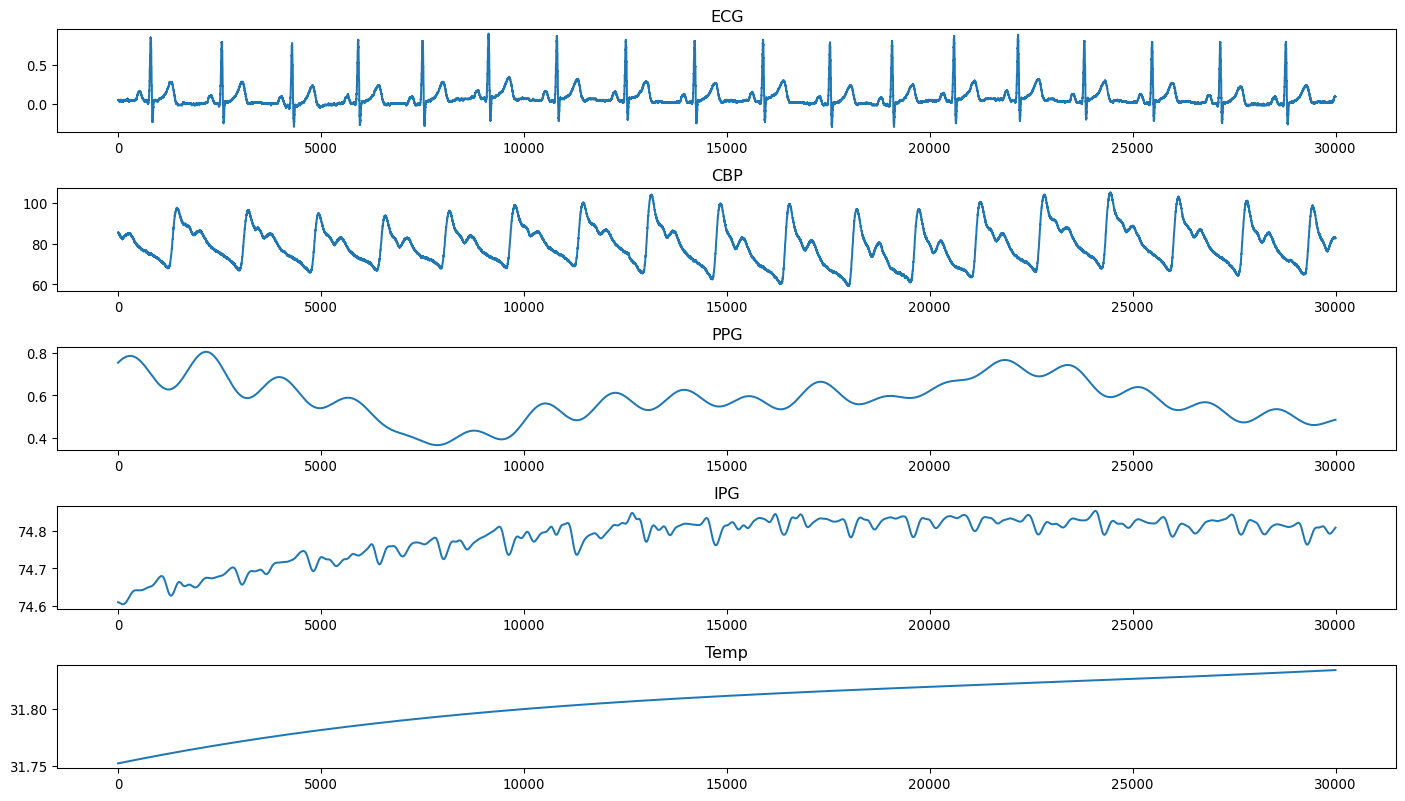

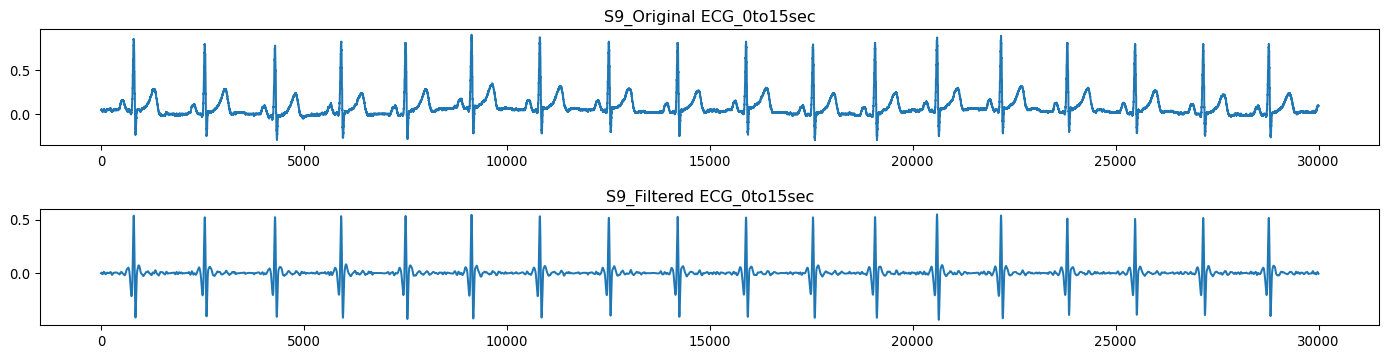

R peak index: 751, [805, 2555, 4287, 5916, 7504, 9129, 10812, 12512, 14207, 15893, 17542, 19072, 20599, 22176, 23810, 25479, 27158, 28774, 30295, 31827, 33398, 35035, 36672, 38248, 39770, 41351, 42953, 44576, 46211, 47809, 49353, 50920, 52497, 54080, 55639, 57098, 58560, 60050, 61567, 63167, 64731, 66330, 67965, 69513, 71047, 72718, 74410, 76060, 77713, 79288, 80795, 82296, 83790, 85313, 86862, 88362, 89928, 91571, 93313, 94954, 96581, 98260, 99942, 101567, 103199, 104739, 106191, 107576, 108976, 110385, 111858, 113381, 114856, 116385, 117935, 119501, 120989, 122531, 124121, 125746, 127395, 129073, 130649, 132216, 133759, 135295, 136831, 138282, 139773, 141291, 142904, 144654, 146327, 147950, 149714, 151545, 153442, 155359, 157130, 158905, 160640, 162343, 163948, 165545, 167175, 168822, 170481, 172098, 173752, 175340, 176897, 178524, 180209, 181911, 183548, 185192, 186826, 188475, 190133, 191726, 193342, 194970, 196596, 198144, 199729, 201377, 203124, 204987, 206803, 208593, 210412, 21

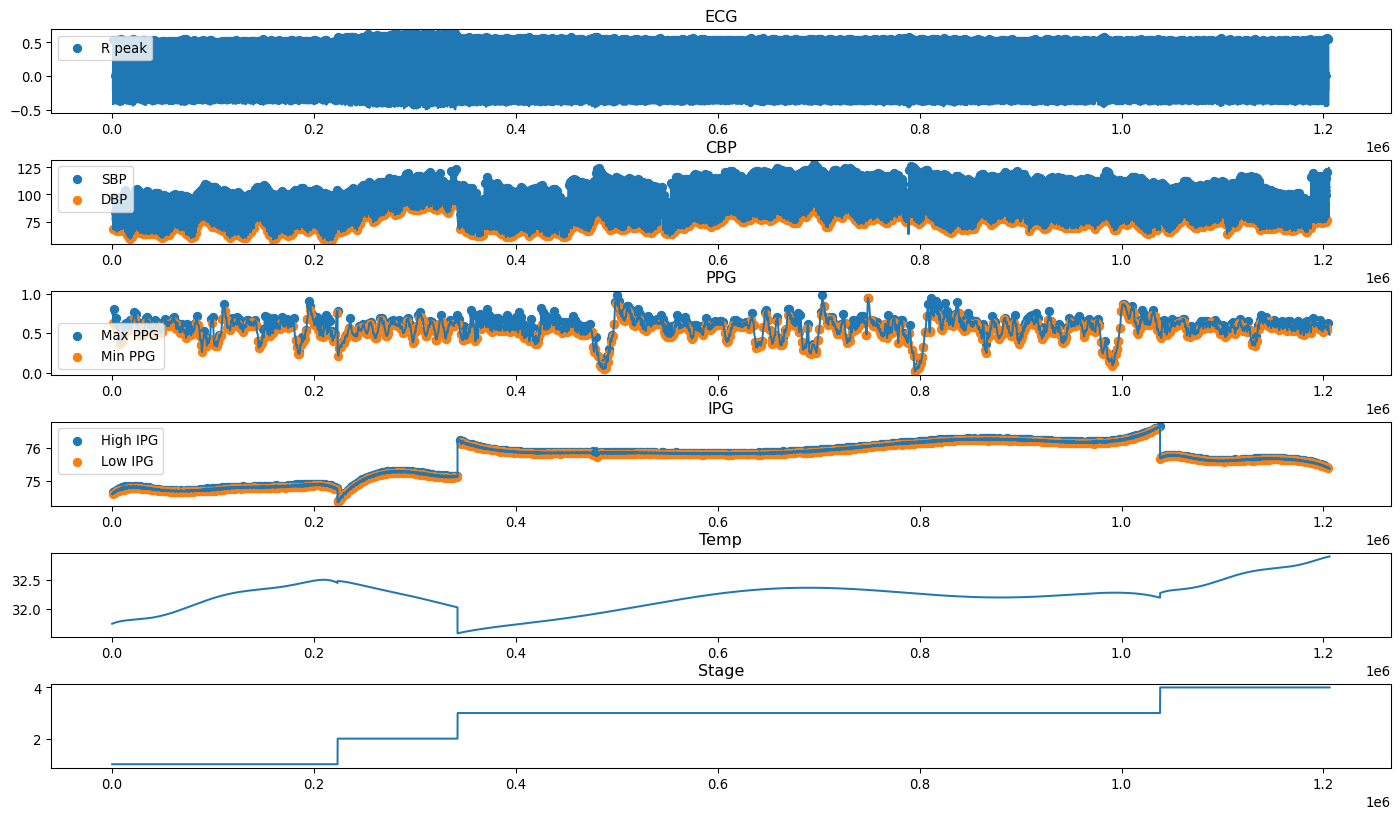

max HR:1.4095, min HR:0.651, len HR:750
max R_peak:0.6418257475203095, min R_peak:0.49375576222343054, len R_peak:750
max PTT:1.214, min PTT:0.0135, len PTT:750
max Max_PPG:0.9882498669351067, min Max_PPG:0.018559804533784287, len Max_PPG:750
max Min_PPG:0.9469224775948325, min Min_PPG:0.014497712767365441, len Min_PPG:750
max dPPG:0.4669546398236485, min dPPG:0.0, len dPPG:750
max PPG_width:1.7495, min PPG_width:0.0175, len PPG_width:750
max High_IPG:76.65635105905243, min High_IPG:74.41886037154923, len High_IPG:750
max Low_IPG:76.56084669669387, min Low_IPG:74.36764537774242, len Low_IPG:750
max dIPG:0.9824282112812313, min dIPG:0.0, len dIPG:750
max IPG_small_area:0.4224075882819606, min IPG_small_area:0.005473222485008208, len IPG_small_area:750
max IPG_large_area:1.7504642648526332, min IPG_large_area:0.050264734518126526, len IPG_large_area:750
max ave_Temp:32.896357818535996, min ave_Temp:31.597876533468657, len ave_Temp:750
max SBP:128.41783720617545, min SBP:88.22622371145162

,Stage,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,1.0,0.8750,0.536972,0.6820,0.806940,0.627878,0.179062,0.9700,74.679271,74.626550,0.052720,0.017170,1.746272,31.763393,97.625629,67.748948,29.876682
1,1.0,0.8660,0.521162,0.7080,0.687038,0.586998,0.100039,0.8940,74.702288,74.656198,0.046090,0.023312,1.698260,31.773533,96.526997,66.833421,29.693576
2,1.0,0.8145,0.522836,0.6890,0.588946,0.539058,0.049889,1.2650,74.746407,74.692417,0.053990,0.018374,1.574023,31.781902,94.818015,65.826342,28.991673
3,1.0,0.8125,0.533881,0.6345,0.432732,0.363842,0.068890,0.7925,74.782163,74.724459,0.057704,0.021180,1.535722,31.794640,96.099752,67.809983,28.289769
4,1.0,0.8415,0.544633,0.7005,0.561842,0.391185,0.170657,0.9265,74.811671,74.735907,0.075763,0.020979,1.573277,31.799822,98.876849,67.871018,31.005831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,4.0,0.8385,0.535778,0.6665,0.664143,0.551222,0.112920,0.9075,75.520333,75.473935,0.046399,0.022989,0.975539,32.858431,117.126344,74.676431,42.449912
621,4.0,0.8410,0.516000,0.6855,0.619904,0.539218,0.080686,0.8460,75.505294,75.462741,0.042553,0.022276,0.990314,32.867287,117.339967,74.859537,42.480430
622,4.0,0.7895,0.536069,0.7300,0.599624,0.519258,0.080366,0.8090,75.486917,75.443209,0.043708,0.020326,0.943594,32.875593,115.234256,74.035563,41.198693
623,4.0,0.7635,0.533610,0.7140,0.597956,0.556863,0.041093,1.2105,75.469570,75.424182,0.045388,0.021640,0.927747,32.883118,112.792852,74.188151,38.604701


Subject 13
['processed_rest2', 'processed_ct_1', 'processed_re_2', 'processed_rest1', 'processed_re_1']
1200497


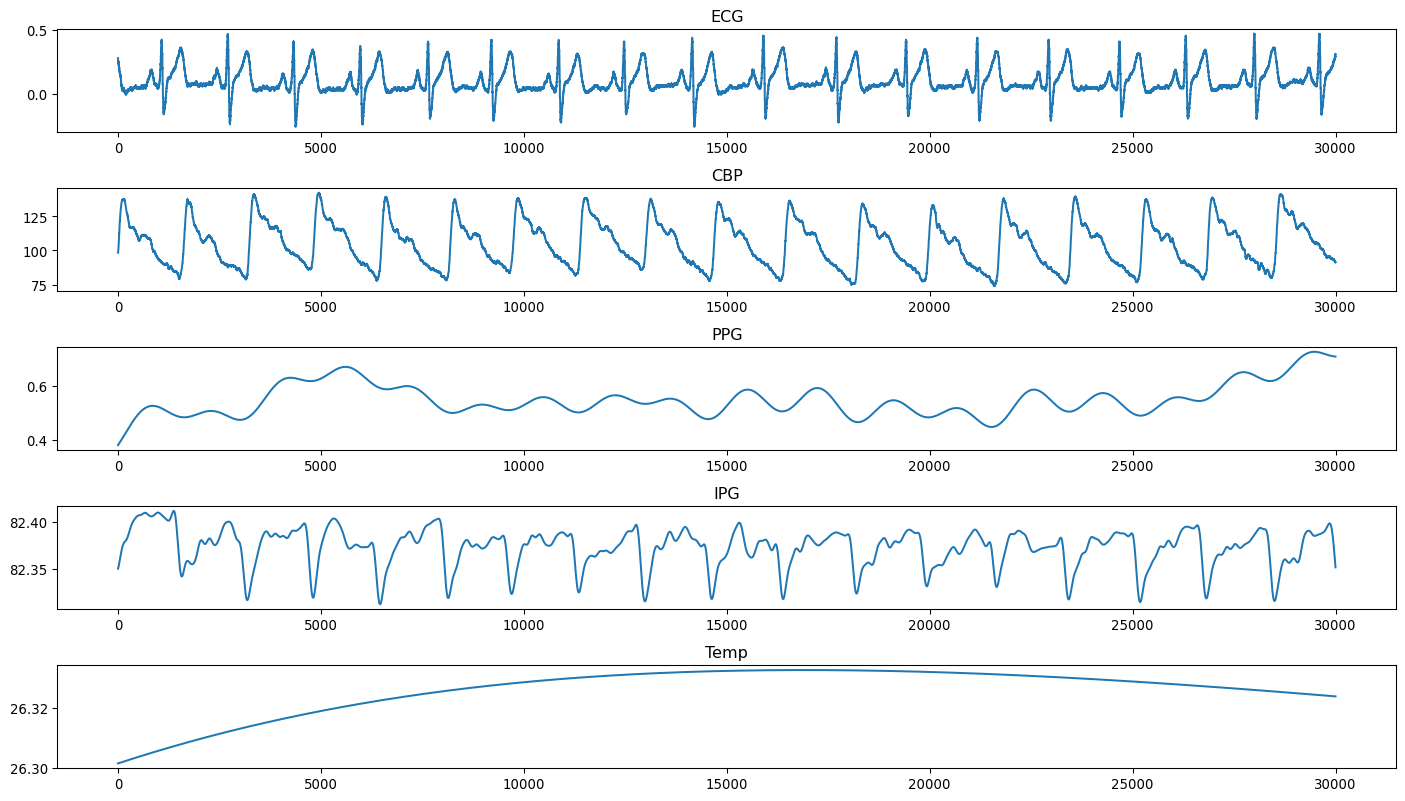

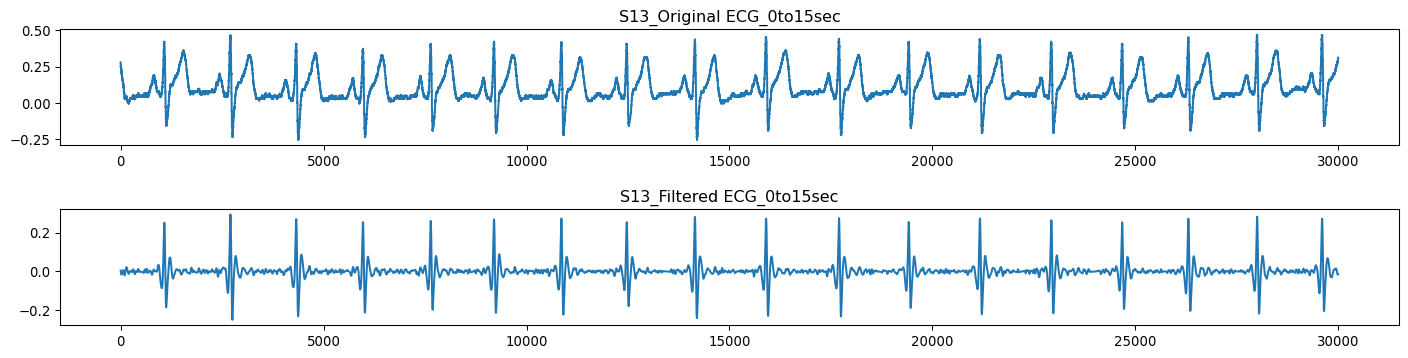

R peak index: 709, [1075, 2704, 4325, 5970, 7640, 9200, 10859, 12470, 14149, 15904, 17700, 19419, 21172, 22932, 24677, 26309, 28002, 29604, 31275, 32955, 34644, 36364, 37958, 39661, 41392, 43158, 44910, 46540, 48197, 49895, 51593, 53248, 54782, 56380, 58043, 59750, 61458, 63095, 64818, 66596, 68402, 70133, 71864, 73656, 75486, 77305, 79015, 80815, 82616, 84400, 86122, 87949, 89817, 91644, 93373, 95156, 96994, 98874, 100618, 102408, 104245, 106076, 107793, 109530, 111318, 113061, 114721, 116497, 118280, 120047, 121637, 123254, 124925, 126656, 128426, 130163, 131830, 133585, 135356, 137112, 138755, 140517, 142267, 144030, 145682, 147396, 149164, 150950, 152736, 154370, 156069, 157853, 159675, 161463, 163197, 164986, 166854, 168684, 170415, 172240, 174071, 175806, 177529, 179347, 181203, 183074, 184808, 186588, 188381, 190155, 191942, 193746, 196770, 198372, 200048, 201746, 203382, 205059, 206764, 208418, 210129, 211812, 213511, 215160, 216709, 218325, 220028, 221791, 223439, 225145, 2268

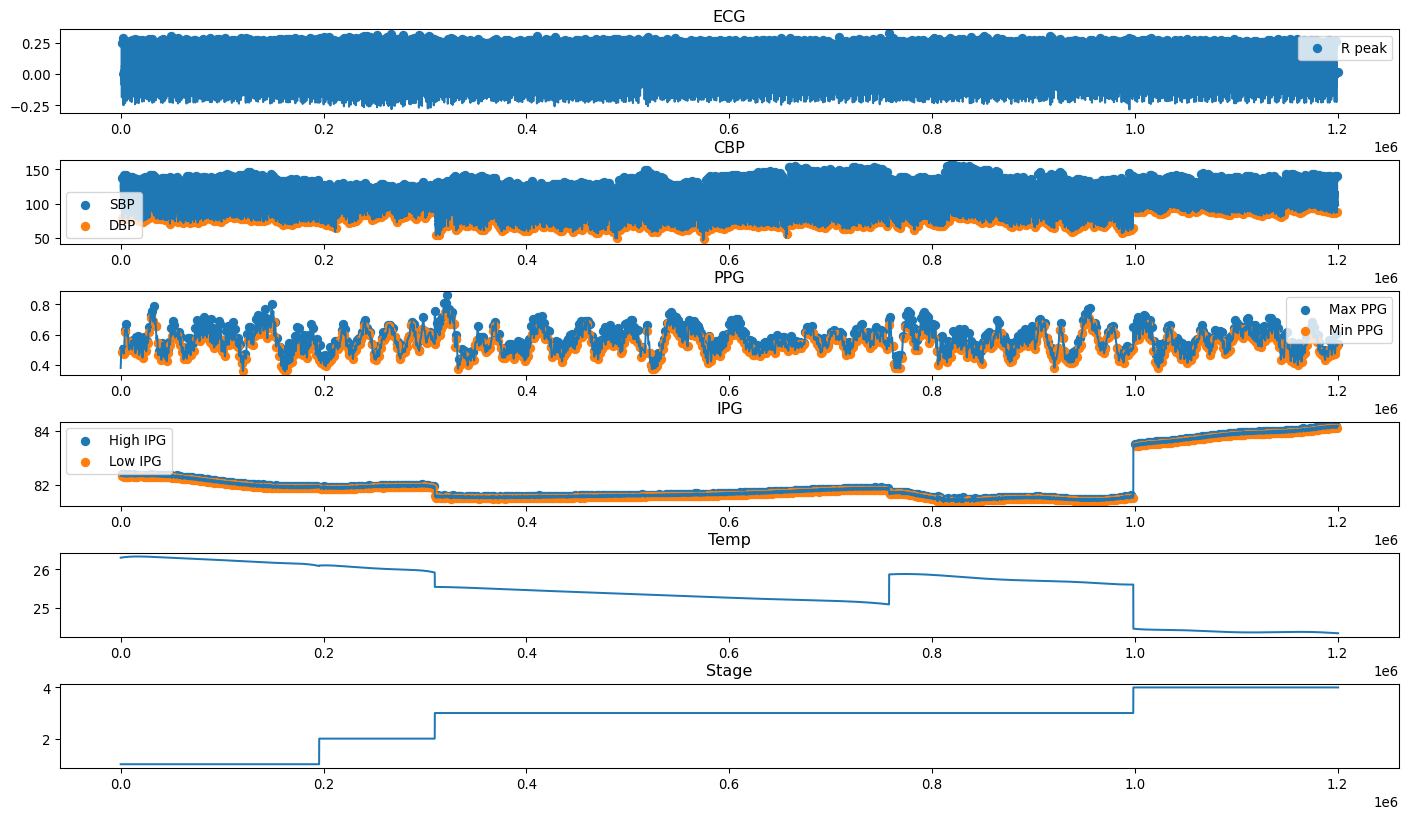

max HR:1.512, min HR:0.6785, len HR:708
max R_peak:0.3333129504226501, min R_peak:0.17313633503764098, len R_peak:708
max PTT:1.376, min PTT:0.089, len PTT:708
max Max_PPG:0.8648426446058042, min Max_PPG:0.4002358283863546, len Max_PPG:708
max Min_PPG:0.749517812756557, min Min_PPG:0.3573692910453178, len Min_PPG:708
max dPPG:0.21990542389272905, min dPPG:0.0, len dPPG:708
max PPG_width:1.6155, min PPG_width:0.0715, len PPG_width:708
max High_IPG:84.2079266238737, min High_IPG:81.43221814721112, len High_IPG:708
max Low_IPG:84.12469637819416, min Low_IPG:81.36603872564861, len Low_IPG:708
max dIPG:0.3815204554022671, min dIPG:0.030633613330977028, len dIPG:708
max IPG_small_area:0.906779855044357, min IPG_small_area:0.011923066743899242, len IPG_small_area:708
max IPG_large_area:3.4057669312912466, min IPG_large_area:0.022023013884036855, len IPG_large_area:708
max ave_Temp:26.332652425318113, min ave_Temp:24.340237261871213, len ave_Temp:708
max SBP:158.44710651430623, min SBP:115.661

,Stage,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,1.0,0.8145,0.251703,0.6085,0.507627,0.483902,0.023725,0.6875,82.411347,82.341828,0.069520,0.026015,1.489329,26.309096,137.664655,78.979406,58.685249
1,1.0,0.8105,0.294314,0.7720,0.631317,0.474360,0.156957,0.8680,82.399991,82.316793,0.083198,0.020867,1.486199,26.314653,141.174173,78.735266,62.438908
2,1.0,0.8225,0.270075,0.6390,0.671969,0.618598,0.053371,1.4495,82.398172,82.319264,0.078908,0.019761,1.504011,26.319324,142.364358,86.059478,56.304880
3,1.0,0.7800,0.260762,0.6655,0.531230,0.500074,0.031156,0.6895,82.403164,82.318916,0.084248,0.024385,1.432100,26.326257,137.420514,78.063880,59.356635
4,1.0,0.8295,0.268380,0.6390,0.559112,0.510525,0.048587,0.8600,82.385152,82.323276,0.061876,0.012159,1.522466,26.328617,138.397076,83.282381,55.114695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,4.0,0.8430,0.265122,0.6760,0.561745,0.453605,0.108140,0.9245,84.180219,84.096649,0.083571,0.022308,0.042253,24.353805,140.991068,87.982083,53.008985
620,4.0,0.8765,0.275076,0.6425,0.565041,0.504914,0.060127,0.9005,84.186456,84.110608,0.075848,0.016302,0.035121,24.351188,140.502787,87.493803,53.008985
621,4.0,0.8195,0.247811,0.7205,0.539698,0.466347,0.073352,1.4005,84.191105,84.116279,0.074825,0.018591,0.032376,24.348513,138.610699,86.242583,52.368116
622,4.0,0.8780,0.267930,0.7185,0.602049,0.474865,0.127184,1.0575,84.198545,84.114836,0.083709,0.023927,0.025986,24.342984,139.770366,86.517241,53.253125


Subject 1
['processed_D29_recover_1_1', 'processed_D29_rest1_1', 'processed_D29_recover_2', 'processed_D29_CT_1_1', 'processed_D29_rest2_1_1', 'processed_D29_rest1_2']
888006


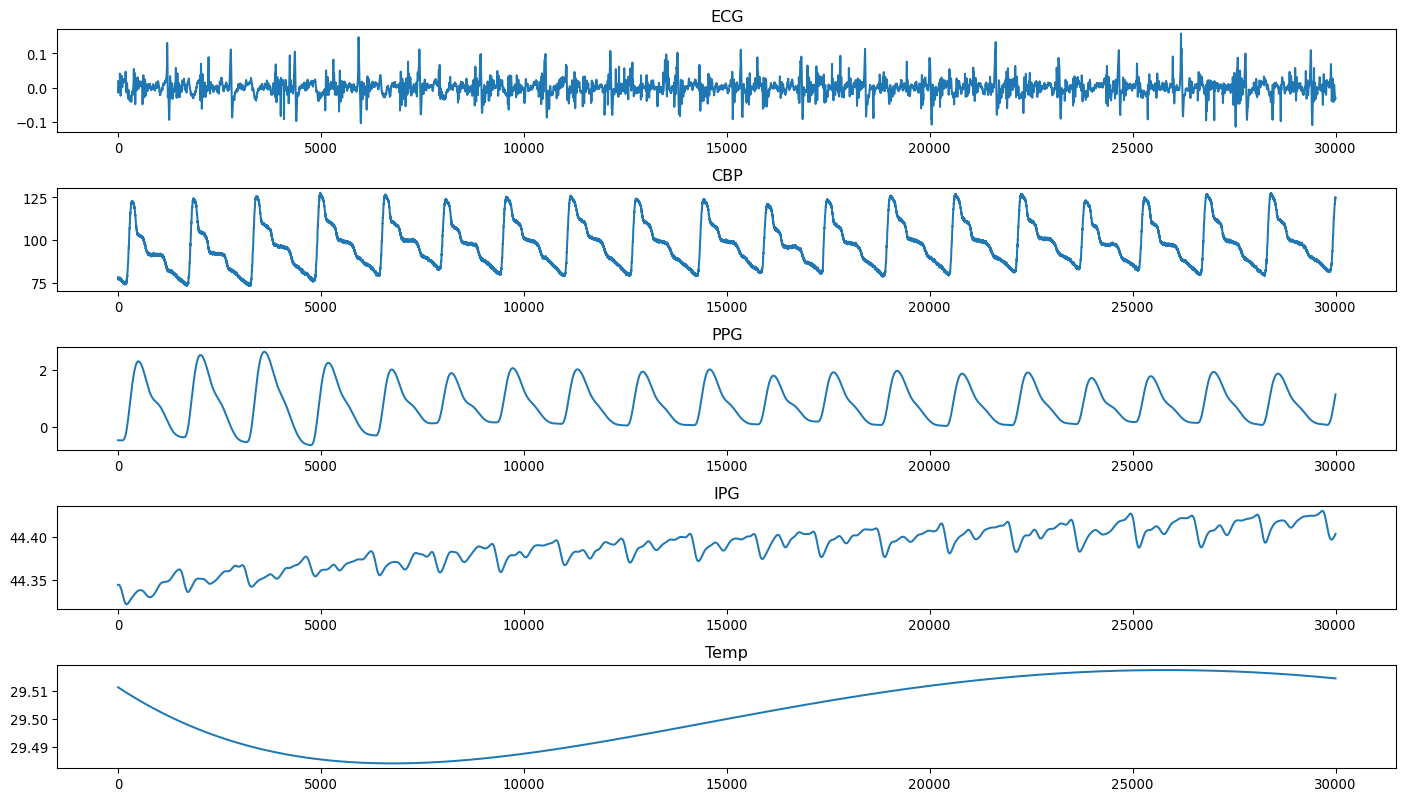

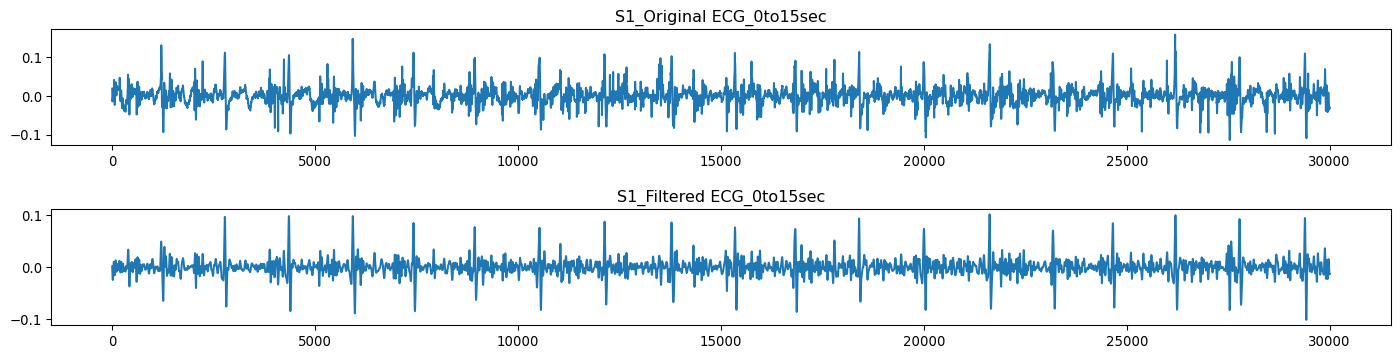

R peak index: 558, [2776, 4355, 5928, 7425, 8932, 10528, 12133, 13783, 15346, 16831, 18404, 20003, 21620, 23181, 24657, 26199, 27778, 29390, 30907, 32430, 34038, 35650, 37226, 38697, 40228, 41775, 43327, 44781, 46256, 47762, 49316, 50875, 52345, 53862, 55423, 57003, 58567, 60022, 61531, 63069, 64639, 66164, 67601, 69088, 70603, 72128, 73591, 75006, 76502, 78044, 79606, 81096, 82514, 84012, 85535, 87059, 88458, 89873, 91372, 92959, 94597, 96203, 97658, 99205, 100811, 102402, 103961, 105428, 106960, 108541, 110128, 111593, 113131, 114710, 116326, 117828, 119320, 120275, 121859, 123315, 124821, 126375, 127983, 129528, 131112, 132784, 134504, 136234, 137854, 139561, 141341, 143167, 144826, 146492, 148222, 149981, 151626, 153186, 154869, 156552, 158262, 159906, 161475, 163151, 164827, 166465, 167980, 169464, 170974, 172527, 174128, 175689, 177206, 178827, 180488, 182183, 183769, 185371, 187051, 188721, 190309, 191817, 193404, 195017, 196661, 198223, 199744, 201362, 203069, 204770, 206354, 2

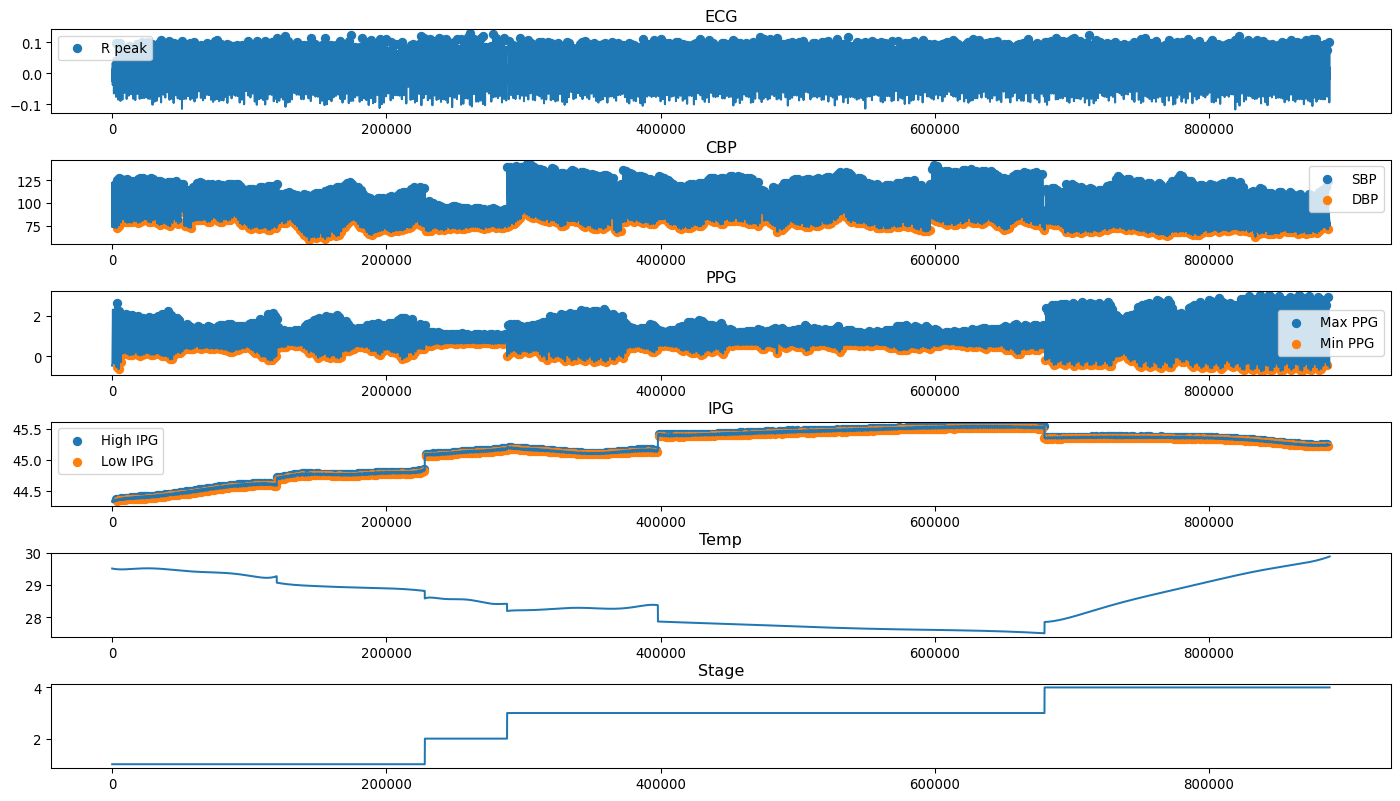

max HR:0.9295, min HR:0.4275, len HR:557
max R_peak:0.13154163396668633, min R_peak:0.062281091088195274, len R_peak:557
max PTT:0.5055, min PTT:0.2655, len PTT:557
max Max_PPG:3.038575866979931, min Max_PPG:0.976472368936435, len Max_PPG:557
max Min_PPG:0.6624143392323292, min Min_PPG:-0.7427869975048409, len Min_PPG:557
max dPPG:3.6196969313669447, min dPPG:0.3304610066554692, len dPPG:557
max PPG_width:1.013, min PPG_width:0.428, len PPG_width:557
max High_IPG:45.557422113460575, min High_IPG:44.3669418545431, len High_IPG:557
max Low_IPG:45.52187648541349, min Low_IPG:44.34160361598648, len Low_IPG:557
max dIPG:0.18795411629076142, min dIPG:0.017516857081432136, len dIPG:557
max IPG_small_area:0.18657109473016567, min IPG_small_area:0.005008697581797793, len IPG_small_area:557
max IPG_large_area:0.9636386065562141, min IPG_large_area:0.01341572525716176, len IPG_large_area:557
max ave_Temp:29.866282701153494, min ave_Temp:27.515381688949713, len ave_Temp:557
max SBP:143.31040165980

,Stage,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,1.0,0.7895,0.097175,0.4145,2.631662,-0.526629,3.158291,0.7935,44.366942,44.341604,0.025338,0.008158,0.948042,29.489265,125.640740,73.028484,52.612256
1,1.0,0.7865,0.098778,0.4130,2.246744,-0.629308,2.876052,0.7995,44.376969,44.353832,0.023137,0.008603,0.937030,29.485417,127.715934,75.469888,52.246046
2,1.0,0.7485,0.098724,0.4080,2.012179,-0.295080,2.307259,0.6880,44.383322,44.355027,0.028294,0.009464,0.888279,29.484218,126.556267,78.918371,47.637896
3,1.0,0.7535,0.085564,0.3950,1.887730,0.131710,1.756020,0.7960,44.382474,44.358280,0.024194,0.009114,0.889585,29.484942,124.084345,82.366854,41.717491
4,1.0,0.7980,0.077317,0.3970,2.060073,0.163667,1.896405,0.8015,44.391909,44.358748,0.033161,0.008538,0.938617,29.487146,125.396600,79.620275,45.776325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,4.0,0.7910,0.093136,0.4275,2.832127,-0.665156,3.497283,0.7765,45.251681,45.230526,0.021155,0.009895,0.251736,29.784559,112.365606,69.030685,43.334921
549,4.0,0.7780,0.089969,0.4325,2.769006,-0.616022,3.385028,0.8045,45.253131,45.230310,0.022821,0.010808,0.247547,29.803046,114.440799,71.319501,43.121298
550,4.0,0.7355,0.093092,0.4340,2.423905,-0.464384,2.888289,0.7825,45.251622,45.231234,0.020388,0.008053,0.232969,29.822143,111.297492,73.944010,37.353481
551,4.0,0.7925,0.094304,0.4305,2.546626,-0.292961,2.839587,0.7215,45.252304,45.230076,0.022228,0.009945,0.249724,29.842837,117.736695,73.150554,44.586141


In [3]:
for i in range(10, 15): 
    process_subject(i)

In [98]:
## Normlize Features
features_norm = {}
features_norm['heart_rate'] = features_fil_df['heart_rate']
features_norm['R_peak'] = [(fi - min(features_fil_df['R_peak'])) / (max(features_fil_df['R_peak']) - min(features_fil_df['R_peak'])) for fi in features_fil_df['R_peak']]#[((i - min_r_peak) / (max_r_peak - min_r_peak)) for i in features_fil_df['R_peak']]#[(i - min(features_fil_df['R_peak'])) / (max(features_fil_df['R_peak']) - min(features_fil_df['R_peak'])) for i in features_fil_df['R_peak']]
features_norm['PTT'] = features_fil_df['PTT']
min_ori_ppg, max_ori_ppg = min(Sub[f"{Sub['sub_id'][i]}"]['PPG']), max(Sub[f"{Sub['sub_id'][i]}"]['PPG'])
features_norm['Max_PPG'] = [(fi - min_ori_ppg) / (max_ori_ppg - min_ori_ppg) for fi in features_fil_df['Max_PPG']]
features_norm['Min_PPG'] = [(fi - min_ori_ppg) / (max_ori_ppg - min_ori_ppg) for fi in features_fil_df['Min_PPG']]
features_norm['dPPG'] = [(features_norm['Max_PPG'][fi] - features_norm['Min_PPG'][fi]) for fi in range(len(features_norm['Max_PPG']))]
features_norm['PPG_width'] = [(fi - min(features_fil_df['PPG_width'])) / (max(features_fil_df['PPG_width']) - min(features_fil_df['PPG_width'])) for fi in features_fil_df['PPG_width']]
min_ori_ipg, max_ori_ipg = min(Sub[f"{Sub['sub_id'][i]}"]['IPG']), max(Sub[f"{Sub['sub_id'][i]}"]['IPG'])
features_norm['High_IPG'] = [(fi - min_ori_ipg) / (max_ori_ipg - min_ori_ipg) for fi in features_fil_df['High_IPG']]#[(i - min(S1_ori['IPG'])) / (max(S1_ori['IPG']) - min(S1_ori['IPG'])) for i in features_fil_df['High_IPG']]
features_norm['Low_IPG'] = [(fi - min_ori_ipg) / (max_ori_ipg - min_ori_ipg) for fi in features_fil_df['Low_IPG']]#[(i - min(S1_ori['IPG'])) / (max(S1_ori['IPG']) - min(S1_ori['IPG'])) for i in features_fil_df['Low_IPG']]
features_norm['dIPG'] = [(features_norm['High_IPG'][fi] - features_norm['Low_IPG'][fi]) for fi in range(len(features_norm['High_IPG']))]
features_norm['IPG_small_area'] = [(fi - min( features_fil_df['IPG_small_area'])) / (max(features_fil_df['IPG_small_area']) - min(features_fil_df['IPG_small_area'])) for fi in features_fil_df['IPG_small_area']]
features_norm['IPG_large_area'] = [(fi - min(features_fil_df['IPG_large_area'])) / (max(features_fil_df['IPG_large_area']) - min(features_fil_df['IPG_large_area'])) for fi in features_fil_df['IPG_large_area']]
features_norm['ave_Temp'] = [(fi - min(features_fil_df['ave_Temp'])) / (max(features_fil_df['ave_Temp']) - min(features_fil_df['ave_Temp'])) for fi in features_fil_df['ave_Temp']]
min_ori_cbp, max_ori_cbp = min(Sub[f"{Sub['sub_id'][i]}"]['CBP']), max(Sub[f"{Sub['sub_id'][i]}"]['CBP'])
features_norm['SBP'] = [(fi - min_ori_cbp) / (max_ori_cbp - min_ori_cbp) for fi in features_fil_df['SBP']]#[(i - min(S1_ori['CBP'])) / (max(S1_ori['CBP']) - min(S1_ori['CBP'])) for i in features_fil_df['SBP']]
features_norm['DBP'] = [(fi - min_ori_cbp) / (max_ori_cbp - min_ori_cbp) for fi in features_fil_df['DBP']]#[(i - min(S1_ori['CBP'])) / (max(S1_ori['CBP']) - min(S1_ori['CBP'])) for i in features_fil_df['DBP']]
features_norm['PBP'] = [(features_norm['SBP'][fi] - features_norm['DBP'][fi]) for fi in range(len(features_norm['SBP']))]

features_norm_df = pd.DataFrame(features_norm)
features_norm_df.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_Normlized_Features.csv")
display(features_norm_df)

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.7945,0.412392,0.5290,0.658300,0.269366,0.388934,0.482372,0.254834,0.214246,0.040587,0.288643,0.765457,0.983804,0.795169,0.219391,0.575778
1,0.8060,0.432510,0.5600,0.701484,0.296086,0.405398,0.501483,0.254729,0.214311,0.040418,0.322559,0.774931,0.981004,0.811714,0.251158,0.560556
2,0.7935,0.292021,0.5670,0.751957,0.326586,0.425371,0.493245,0.261710,0.222635,0.039075,0.294180,0.757140,0.977846,0.853408,0.277962,0.575447
3,0.7730,0.293343,0.5780,0.740351,0.333873,0.406478,0.463262,0.261659,0.224767,0.036892,0.225314,0.734041,0.974454,0.840503,0.300794,0.539709
4,0.7580,0.443102,0.5805,0.755196,0.355196,0.400000,0.462932,0.264251,0.230857,0.033395,0.191258,0.714969,0.970897,0.846459,0.304434,0.542025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.7640,0.495061,0.5295,0.537112,0.155466,0.381646,0.477430,0.188507,0.150263,0.038245,0.467079,0.809983,0.141388,0.920251,0.343481,0.576770
836,0.7855,0.438274,0.5230,0.565722,0.194872,0.370850,0.487644,0.189488,0.147512,0.041976,0.261102,0.825075,0.147814,0.941760,0.349768,0.591992
837,0.7625,0.222271,0.5270,0.591903,0.163833,0.428070,0.464580,0.190744,0.148432,0.042312,0.319431,0.797760,0.155187,0.955328,0.354732,0.600596
838,0.7655,0.235947,0.5190,0.557625,0.195142,0.362483,0.467545,0.198831,0.158176,0.040656,0.272502,0.794070,0.163471,0.925546,0.360357,0.565189
